# 문제 : 다음 분기에 어떤 게임을 설계해야 할까

1.   지역에 따라서 선호하는 게임 장르가 다를까?
2.   연도별 게임의 트렌드가 있을까?
3.   출고량이 높은 게임에 대한 분석 및 시각화 프로세스
4.   다음 분기에 어떤 게임을 설계해야 할까?

# Preprocessing & Functions

In [1]:
import os
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import cluster

df = pd.read_csv("./drive/MyDrive/Colab Notebooks/N1xx Section1/vgames2.csv", index_col=0)
df.isna().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [2]:
# 결측치 제거 및 수치 일관화
def km_remove (x) :
    if "K" in x : return float(x.replace("K",""))/1000
    return float(x.replace("M",""))

def year_prep (x) :
    if 0<=x<50 : return int(x+2000)
    elif 50<x<100 : return int(x+1900)
    try : return int(x)
    except : return 2020 ## 알 수 없는 년도 데이터를 2020으로 둔다.

df_prep = df.copy()#.dropna().reset_index(drop=True)

# df_prep.isna().sum()
df_prep["Genre"] = df_prep["Genre"].fillna("Unknown")
df_prep["Publisher"] = df_prep["Publisher"].fillna("Unknown")



# df_prep.isna().sum()
df_prep.loc[:,"NA_Sales":"Other_Sales"] = df_prep.loc[:,"NA_Sales":"Other_Sales"].applymap(km_remove)
df_prep["Year"] = df_prep["Year"].apply(year_prep)
df_prep["Total_Sales"] = df_prep.iloc[:,-4:].sum(axis=1)

## 기타 정리
# Unknown 이지만 롤플레잉
df_prep.loc[(df_prep["Name"] == "Pokemon X/Pokemon Y"),"Genre"] = "Role-Playing" ## Unknown 이지만 롤 플레잉.
# 년도 표기 오류
df_prep.loc[df_prep["Year"]==2017,"Year"] = 2016 ## 2017년 작으로 되어 있는 게임은 사실 2016년 작.
# 장르가 둘 이상인 것
df_prep.loc[(df_prep["Name"] == "Culdcept"), "Genre"] = "Misc"
df_prep.loc[(df_prep["Name"] == "Little Busters! Converted Edition"), "Genre"] = "Adventure"
df_prep.loc[(df_prep["Name"] == "Steins;Gate: Hiyoku Renri no Darling"), "Genre"] = "Adventure"
df_prep.loc[(df_prep["Name"] == "Syndicate"), "Genre"] = "Shooter"

# df_prep.drop(df_prep[df_prep["Year"]==2020].index, inplace=True) ## 2020년 데이터는 이상하다. 2017년 다음에 2020으로 바로 뜀. 제거 해 준다.
df_prep

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
1,Candace Kane's Candy Factory,DS,2008,Action,Destineer,0.04,0.00,0.00,0.00,0.04
2,The Munchables,Wii,2009,Action,Namco Bandai Games,0.17,0.00,0.00,0.01,0.18
3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
4,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25
...,...,...,...,...,...,...,...,...,...,...
16594,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,0.15,0.04,0.00,0.01,0.20
16595,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,0.01,0.00,0.00,0.00,0.01
16596,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,0.44,0.19,0.03,0.13,0.79
16597,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,0.05,0.05,0.25,0.03,0.38


In [3]:
# 랭크를 구하는 함수
def rank (df, n) :
    return pd.DataFrame(list(df.apply(lambda s: s.abs().nlargest(n).index.tolist(), axis=1)),columns=[f"Rank{i+1}" for i in range(n)],index=df.index)

def percent (df) :
    return pd.DataFrame(np.round(np.array(df)/np.array([df.sum(axis=1)]).T*100,1), index = df.index, columns=df.columns)

def heatmap (df, figsize=(15,10), rotation=(None, None), ha="center", square=False) :
    plt.figure(figsize=figsize)
    # plt.pcolor(df, edgecolors="face")
    sns.heatmap(df,annot=True, linewidths=0.01, linecolor='white',cmap="YlGnBu",fmt='g',square=square)
    plt.xticks(np.arange(0.5,len(df.columns)+0.5), df.columns, rotation=rotation[0], ha=ha)
    plt.yticks(np.arange(0.5, len(df.index)+0.5), df.index, rotation=rotation[1])
    # plt.colorbar()
    plt.show()

# 1. 지역별 선호하는 장르

## 분석

지역별 선호하는 장르를 확인하기 위해서 groupby를 통해 각 지역 대한 장르별로 판매량의 총 합을 구한다. 

In [4]:
df_R_G = df_prep.groupby("Genre").sum().drop("Year",axis=1)
df_R_G_T = df_R_G.transpose()
df_R_G_T

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,Unknown
NA_Sales,874.81,105.66,223.20,408.06,446.44,123.35,357.19,324.71,581.92,182.96,680.52,68.69,15.44
EU_Sales,522.16,64.05,101.22,212.37,201.61,50.73,237.10,187.63,313.10,113.35,376.48,45.26,9.07
JP_Sales,157.81,52.04,87.34,105.27,130.65,56.87,56.40,349.29,38.28,63.70,135.37,49.46,8.54
Other_Sales,186.45,16.81,36.64,74.04,51.53,12.52,77.10,57.75,102.66,31.48,134.67,11.35,4.75
Total_Sales,1741.23,238.56,448.40,799.74,830.23,243.47,727.79,919.38,1035.96,391.49,1327.04,174.76,37.80


귀무가설 -> 장르별 판매량과 지역별 판매량은 독립적이다.

대립가설 -> 장르별 판매량과 지역별 판매량은 의존적이다.

In [5]:
df_R_G_corr = df_R_G.corr()
df_R_G_corr

,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
NA_Sales,1.000000,0.988305,0.367058,0.976208,0.984976
EU_Sales,0.988305,1.000000,0.361032,0.993830,0.983276
JP_Sales,0.367058,0.361032,1.000000,0.335876,0.509499
Other_Sales,0.976208,0.993830,0.335876,1.000000,0.971433
Total_Sales,0.984976,0.983276,0.509499,0.971433,1.000000


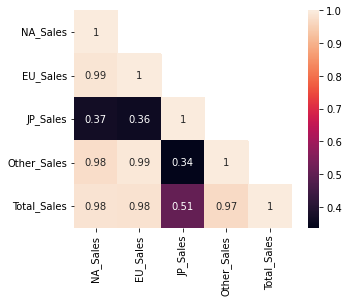

In [6]:
mask = np.array(df_R_G_corr)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(df_R_G_corr,mask=mask, square=True,annot=True)

상관관계 계수(Correlation coefficient)를 확인해보면 JP_Sales를 제외하곤 상관계수가 높다. 

즉, JP 지역만 선호하는 장르의 경향성이 다른 것을 확인할 수 있다.

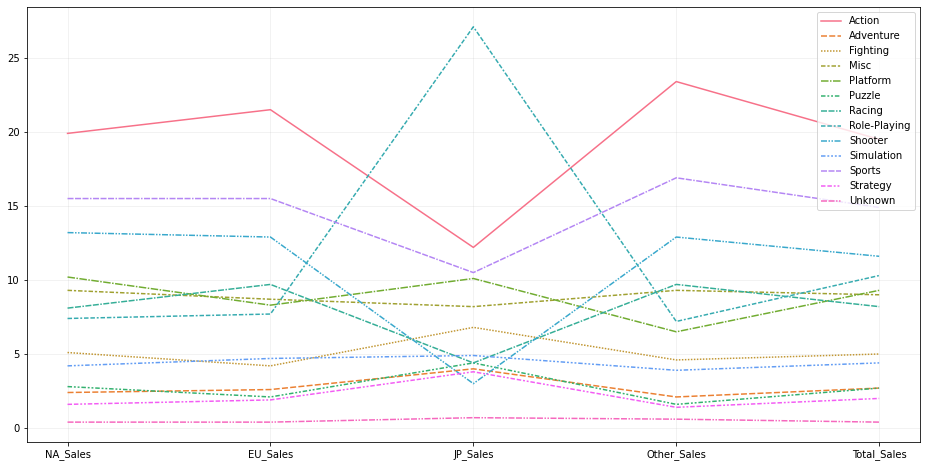

In [7]:
# 우선, 각 지역별 장르가 차지하는 percentage를 구한다.
df_R_G_percent = percent(df_R_G_T)
plt.figure(figsize=(16,8))
plt.grid(alpha=0.2)
sns.lineplot(data=df_R_G_percent)
plt.legend(loc="upper right")

범주가 너무 많아서 line plot으로 한 눈에 확인하기 어렵다.

따라서 10% 이상 비율을 차지하는 장르만 따로 뽑아서 나머지는 Others 항목으로 모아준 후, pie plot으로 한 눈에 확인하기 쉽게 그래프를 그린다.


Donut plot


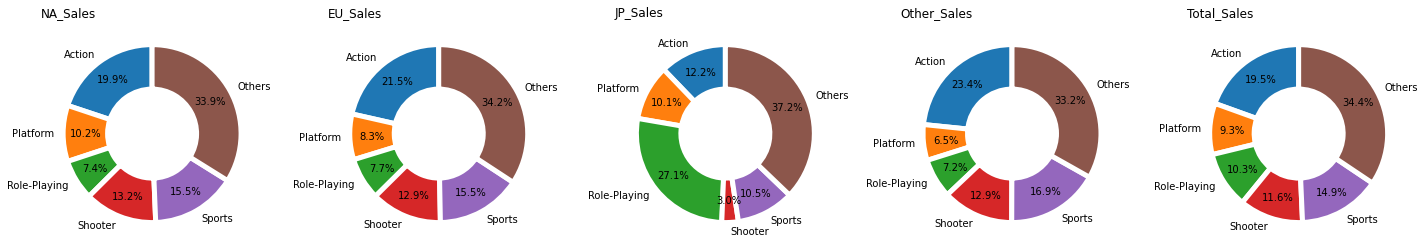

In [8]:
df_R_G_10percent = df_R_G_percent[df_R_G_percent>10].dropna(axis=1, how="all").fillna(df_R_G_percent) # 10% 이상 차지하는 범주만 남기고 제거한다.
df_R_G_10percent["Others"] = df_R_G_percent.drop(columns=df_R_G_10percent.columns).sum(axis=1) # 제거한 값들은 Others 값으로 합쳐서 추가한다.

print("\nDonut plot")
fig,axes = plt.subplots(ncols=5)
fig.set_size_inches(20,4)
for i in range(5) :
    axes[i].pie(df_R_G_10percent.iloc[i,:], 
                labels=df_R_G_10percent.columns, 
                autopct='%.1f%%', pctdistance=0.75, 
                counterclock=True,startangle=90, 
                wedgeprops=dict(width=0.5, edgecolor="white", linewidth=5))
    axes[i].set_title(df_R_G_10percent.index[i],loc="left")
plt.tight_layout()
plt.show()


In [9]:
# rank 함수를 사용. 위에 정의 되어있다.
df_R_G_rank = rank(df_R_G_percent, 3)
df_R_G_rank

,Rank1,Rank2,Rank3
NA_Sales,Action,Sports,Shooter
EU_Sales,Action,Sports,Shooter
JP_Sales,Role-Playing,Action,Sports
Other_Sales,Action,Sports,Shooter
Total_Sales,Action,Sports,Shooter


각 지역 별로 판매량이 높은 장르 순으로 3순위까지 정리하면 위 태이블 처럼 나온다.

JP 지역을 제외한 지역의 장르의 판매순위가 전체 지역의 장르의 판매순위와 똑같다.

In [10]:
# 가설 검정
print("지역 간 chi2 p-value 확인")
print("P-value :",stats.chi2_contingency(df_R_G_percent.iloc[:-1,:])[1])
print("지역에 따른 장르별 판매량이 독립적일 수 있다.")
print()

# print("지역 간 chi2 p-value 확인(일본 제외)")
# print("P-value :",stats.chi2_contingency(df_R_G_percent.iloc[[0,1,3],:])[1])
# print("지역에 따른 장르별 판매량이 독립적이다.(일본 제외)")
# print()

# print("일본 지역과 각 지역간의 chi2 p-value 확인")
# for i in [0,1,3] :
#     print(stats.chi2_contingency(df_R_G_percent.iloc[[i,2],:])[1])

지역 간 chi2 p-value 확인
P-value : 0.15280220150140283
지역에 따른 장르별 판매량이 독립적일 수 있다.



2010년 부터 전체 판매량 대비 일본의 판매량 비율

In [11]:
percent(df_prep[df_prep["Year"]>=2010].groupby("Year").sum().iloc[:-1,:-1])

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
Year,,,,
2010,50.7,29.4,9.9,10.0
2011,46.7,32.5,10.3,10.5
2012,42.7,32.7,14.2,10.4
2013,42.1,34.2,12.9,10.8
2014,39.1,37.3,11.7,11.9
2015,38.9,37.0,12.8,11.4
2016,32.0,37.7,19.4,10.9


2010년 이후로 볼 때, 전체적으로 일본의 비율이 크지 않다.

즉, 특정 장르를 제외하고는 일본 시장을 고려할 이유는 적을 것.

## 결론 

1.   각 지역에 따른 장르별 판매량은 의존적이라고 하기 어렵다.
2.   일본을 제외한다면, 각 지역에 따른 장르별 판매량은 확실하게 독립적이다.
3.   일본의 전체적인 판매량이 나머지 지역과 비교했을 때 비교적 적으므로, 특정장르를 제외한다면 지역별 판매량을 고려할 필요가 없을 것.




In [12]:
# # 최근 5년, 즉 2012년 ~ 2016년 트랜드를 만 반영해본다.
# df_R_G_5y = df_prep[(df_prep["Year"]>=2015)&(df_prep["Year"]<=2019)].groupby("Genre").sum().drop("Year",axis=1).transpose()
# df_R_G_rank_5y = rank(df_R_G_5y, 5)
# df_R_G_rank_5y

# 2. 년도별 게임 트렌드


## 분석
1.   년도별 특정 장르 판매량 추이
2.   년도별 특정 장르 출시량 추이
3.   년도별 특정 장르 출시량 대비 판매량 추이

### 년도별 특정 장르 판매량 추이

In [13]:
## Platform, Publisher가 다르고 타이틀이 같은 게임을 묶기.
df_prep_title = df_prep.iloc[:,[0,5,6,7,8,9]].groupby("Name").sum()
df_prep_title["Platform"] = df_prep.iloc[:,[0,1]].groupby("Name")["Platform"].apply(set)
df_prep_title["Year"] = df_prep.iloc[:,[0,2]].groupby("Name").min()
df_prep_title["Genre"] = df_prep.iloc[:,[0,3]].groupby("Name")["Genre"].apply(set)
df_prep_title["Publisher"] = df_prep.iloc[:,[0,4]].groupby("Name")["Publisher"].apply(set)
df_prep_title = df_prep_title[["Year","Platform", "Genre","Publisher","NA_Sales","EU_Sales","JP_Sales","Other_Sales","Total_Sales"]]

def remove_unknown (x) :
    if len(x) > 1 :
        x.discard("Unknown")
    return list(x)[0]

df_prep_title["Genre"] = df_prep_title["Genre"].apply(remove_unknown)
df_prep_title["Publisher"] = df_prep_title["Publisher"].apply(remove_unknown)

In [14]:
# df_y_prep = df_prep.copy()
def year_dig (x) :
    return int(x - x % 3)

# df_prep_title["Year"] = df_prep_title["Year"].apply(year_dig)
# df_prep_title
df_Y_S_pivot = df_prep_title.groupby(["Year","Genre"]).sum().iloc[:,-1:].reset_index().pivot(index="Year",columns="Genre").fillna(0)#.iloc[:-1]
df_Y_S_pivot.columns = df_Y_S_pivot.columns.get_level_values(1)

df_Y_S_pivot["Total_Sales"] = df_Y_S_pivot.sum(axis=1)

df_Y_S_pivot = df_Y_S_pivot.iloc[15:-1,:] # 어느정도 판매량이 보장되는 1995년 부터 트랜드 조사.
# df_Y_S_pivot = df_Y_S_pivot.iloc[:-1]
pd.concat((df_Y_S_pivot,rank(df_Y_S_pivot.iloc[:,:-1], 4)),axis = 1)

,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,Unknown,Total_Sales,Rank1,Rank2,Rank3,Rank4
Year,,,,,,,,,,,,,,,,,,
1995,3.58,0.64,16.14,7.45,19.60,3.00,6.09,17.68,3.99,5.11,6.66,6.62,0.00,96.56,Platform,Role-Playing,Fighting,Misc
1996,21.63,4.36,16.77,10.79,38.72,3.69,27.91,44.58,7.21,9.73,18.67,6.13,0.42,210.61,Role-Playing,Platform,Racing,Action
1997,24.88,5.01,11.63,9.17,21.80,5.85,32.00,23.04,22.76,10.90,30.43,7.39,0.00,204.86,Racing,Sports,Action,Role-Playing
1998,44.16,9.04,32.92,11.10,30.92,6.29,27.55,26.84,14.12,7.18,43.31,14.25,1.16,268.84,Action,Sports,Fighting,Platform
1999,26.74,7.55,13.03,20.61,14.38,0.53,38.59,46.84,11.70,11.46,31.23,17.35,1.96,241.97,Role-Playing,Racing,Sports,Action
2000,29.78,2.85,21.42,15.24,13.58,4.41,22.94,29.48,6.73,7.05,43.20,8.52,0.00,205.20,Sports,Action,Role-Playing,Racing
2001,57.74,9.66,17.80,18.22,36.27,10.21,55.73,22.74,25.73,19.79,50.48,7.59,2.88,334.84,Action,Racing,Sports,Platform
2002,92.37,10.44,24.62,15.49,40.96,3.07,29.73,46.49,47.86,10.67,65.49,5.50,0.07,392.76,Action,Sports,Shooter,Role-Playing
2003,65.24,2.12,23.22,23.15,35.69,1.66,51.59,30.51,30.59,17.42,65.02,8.00,0.71,354.92,Action,Sports,Racing,Platform


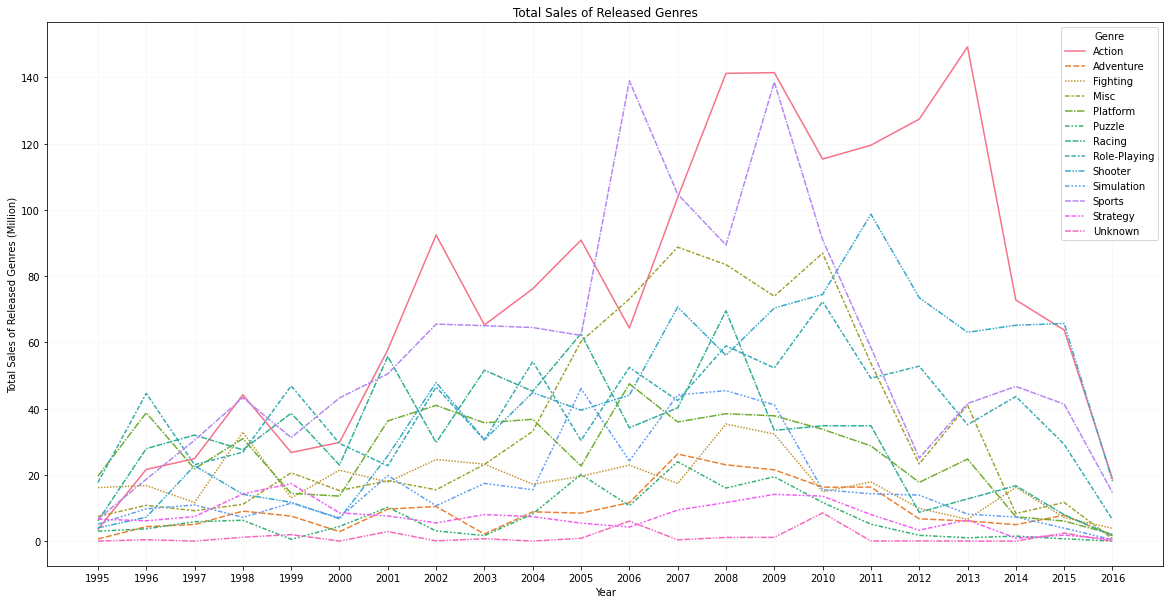

In [15]:
plt.figure(figsize=(20,10))
plt.grid(alpha=0.1)
plt.title("Total Sales of Released Genres")
plt.ylabel("Total Sales of Released Genres (Million)")
plt.xticks(ticks=np.arange(df_Y_S_pivot.index[0], df_Y_S_pivot.index[-1]+1, step=1))
# plt.xticks(ticks=range(5), labels = [1996 + 5*i for i in range(5)])
sns.lineplot(data = df_Y_S_pivot.iloc[:,:13])

각 년도별 스케일이 다르기 때문에 년도별 percent로 어떤 장르의 비율이 높은지 확인한다.

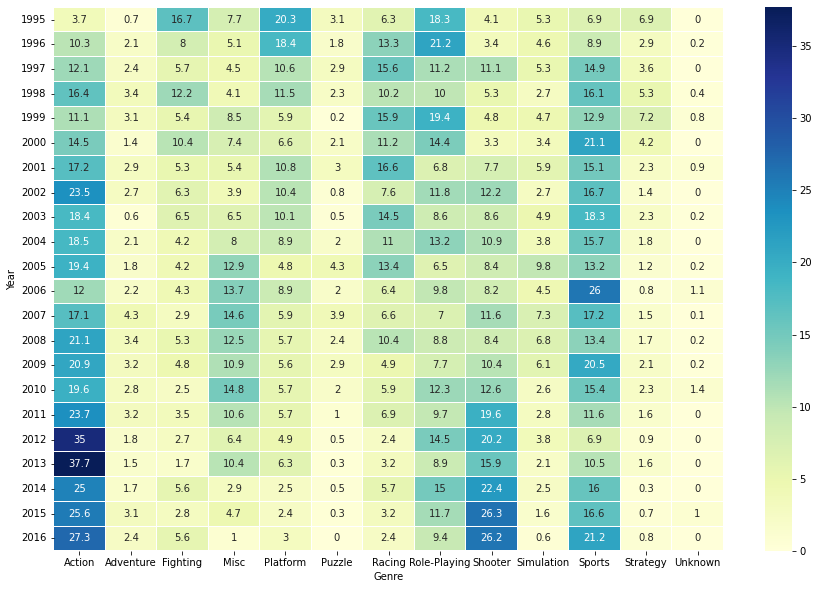

In [16]:
df_Y_S_percent = percent(df_Y_S_pivot.iloc[:,:13])
heatmap(df_Y_S_percent)

위의 히트맵을 보면 각 년도별 판매량으로 트랜드를 분석할 수 있다.

In [17]:
# df_Y_S_percent_corr = df_Y_S_percent.iloc[:].transpose().corr()
# mask = np.array(df_Y_S_percent_corr)
# mask[np.tril_indices_from(mask)] = False
# plt.figure(figsize=(20,15))
# sns.heatmap(df_Y_S_percent_corr, mask=mask, square=True,annot=True)

In [18]:
# corr_d_list = []
# for j in range(len(df_Y_S_percent_corr)-1) :
#     temp = 0
#     for i in range(len(df_Y_S_percent_corr)-j-1) :
#         temp += np.array(df_Y_S_percent_corr)[1+i+j][i]**2
#     corr_d_list.append(temp/(len(df_Y_S_percent_corr)-j-1))
# corr_d_array = np.sqrt(np.array(corr_d_list))

# plt.plot(corr_d_array)

### 년도별 특정 장르 출시량 추이

In [19]:
# 년도별 출시한 장르 수
df_Y_G = pd.crosstab(df_prep_title["Year"],df_prep_title["Genre"]).iloc[15:-1,:] ## 연도별 판매량과 데이터 수를 맞춘다.
df_Y_G_percent = percent(df_Y_G)
pd.concat((df_Y_G_percent,rank(df_Y_G_percent, 4)),axis = 1)

,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,Unknown,Rank1,Rank2,Rank3,Rank4
Year,,,,,,,,,,,,,,,,,
1995,3.4,5.8,13.0,10.6,6.2,5.8,5.8,11.5,13.0,6.2,12.5,6.2,0.0,Fighting,Shooter,Sports,Role-Playing
1996,7.6,6.8,9.2,9.2,5.6,2.8,8.4,11.2,8.8,4.4,20.9,4.4,0.4,Sports,Role-Playing,Fighting,Misc
1997,9.7,4.8,8.2,4.1,6.3,4.8,13.0,8.2,10.0,7.1,16.4,7.4,0.0,Sports,Racing,Shooter,Action
1998,11.6,6.4,9.9,5.5,7.0,3.5,12.8,6.7,5.5,2.3,18.8,9.6,0.6,Sports,Racing,Action,Fighting
1999,11.3,6.2,6.8,6.8,4.5,1.7,15.4,10.3,4.1,6.8,17.8,7.5,0.7,Sports,Racing,Action,Role-Playing
2000,11.5,4.9,7.9,6.2,6.2,3.6,12.2,8.9,5.6,4.9,22.7,5.3,0.0,Sports,Racing,Action,Role-Playing
2001,14.3,4.1,4.1,6.1,9.7,3.4,13.8,9.5,7.5,6.8,15.3,4.9,0.5,Sports,Action,Racing,Platform
2002,15.9,6.1,6.6,6.3,8.7,2.6,10.8,8.9,8.7,3.0,18.8,3.3,0.3,Sports,Action,Racing,Role-Playing
2003,16.5,2.0,6.9,8.3,9.6,1.0,11.8,9.1,8.5,5.1,15.0,5.9,0.2,Action,Sports,Racing,Platform


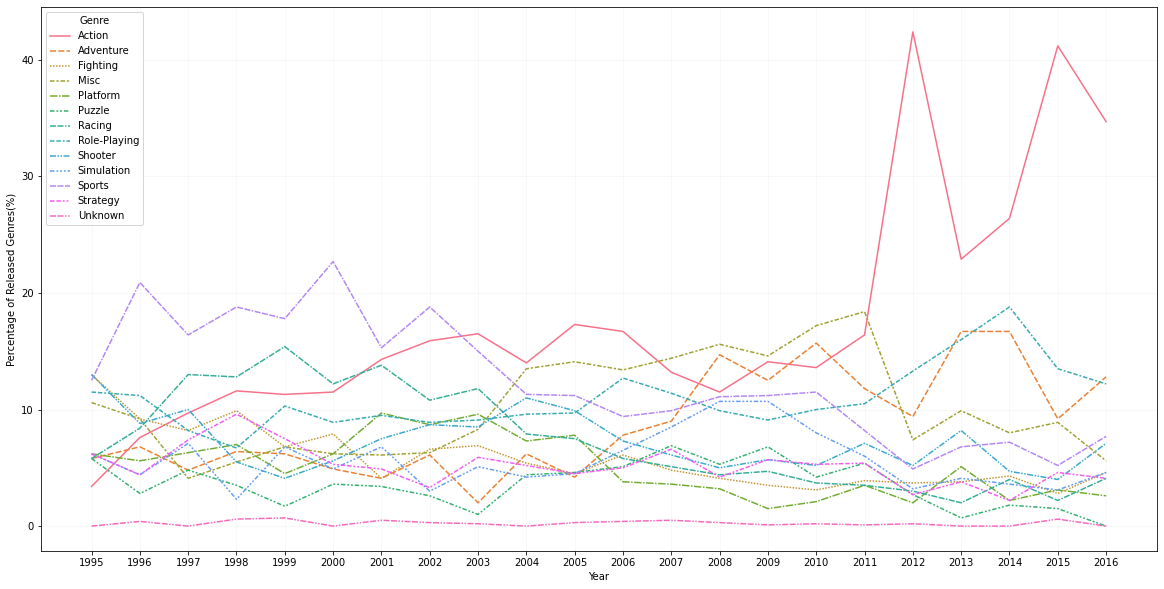

In [20]:
plt.figure(figsize=(20,10))
plt.grid(alpha=0.1)
plt.ylabel("Percentage of Released Genres(%)")
plt.xticks(ticks=np.arange(df_Y_G_percent.index[0], df_Y_G_percent.index[-1]+1, step=1))
sns.lineplot(data = df_Y_G_percent)

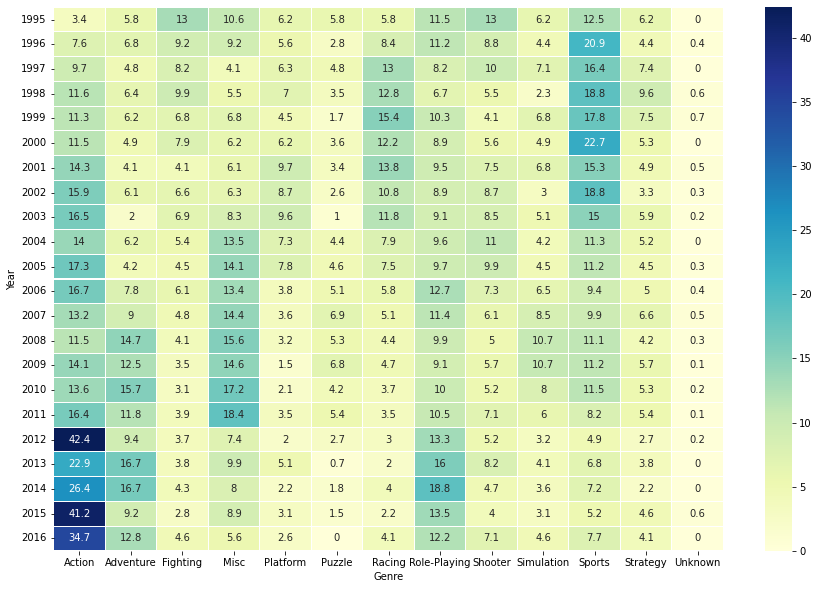

In [21]:
heatmap(df_Y_G_percent)

### 년도별 특정 장르 출시량 대비 판매량 추이

In [22]:
# 각 장르별 출시 게임 당 판매량
df_Y_S_per_n = df_Y_S_pivot.iloc[:,:12]/df_Y_G.iloc[:,:-1]
pd.concat((df_Y_S_per_n,rank(df_Y_S_per_n.iloc[:,:-1], 4)),axis = 1)


,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,Rank1,Rank2,Rank3,Rank4
Year,,,,,,,,,,,,,,,,
1995,0.511429,0.053333,0.597778,0.338636,1.507692,0.250000,0.507500,0.736667,0.147778,0.393077,0.256154,0.509231,Platform,Role-Playing,Fighting,Action
1996,1.138421,0.256471,0.729130,0.469130,2.765714,0.527143,1.329048,1.592143,0.327727,0.884545,0.359038,0.557273,Platform,Role-Playing,Racing,Action
1997,0.956923,0.385385,0.528636,0.833636,1.282353,0.450000,0.914286,1.047273,0.842963,0.573684,0.691591,0.369500,Platform,Role-Playing,Action,Racing
1998,1.104000,0.410909,0.968235,0.584211,1.288333,0.524167,0.626136,1.166957,0.743158,0.897500,0.666308,0.431818,Platform,Role-Playing,Action,Fighting
1999,0.810303,0.419444,0.651500,1.030500,1.106154,0.106000,0.857556,1.561333,0.975000,0.573000,0.600577,0.788636,Role-Playing,Platform,Misc,Shooter
2000,0.850857,0.190000,0.892500,0.802105,0.714737,0.400909,0.620000,1.091852,0.395882,0.470000,0.626087,0.532500,Role-Playing,Fighting,Action,Misc
2001,0.978644,0.568235,1.047059,0.728800,0.906750,0.729286,0.977719,0.583077,0.830000,0.706786,0.801270,0.379500,Fighting,Action,Racing,Platform
2002,1.015055,0.298286,0.647895,0.430278,0.819200,0.204667,0.479516,0.911569,0.957200,0.627647,0.606389,0.289474,Action,Shooter,Role-Playing,Platform
2003,0.805432,0.212000,0.682941,0.564634,0.759362,0.332000,0.889483,0.678000,0.728333,0.696800,0.878649,0.275862,Racing,Sports,Action,Platform


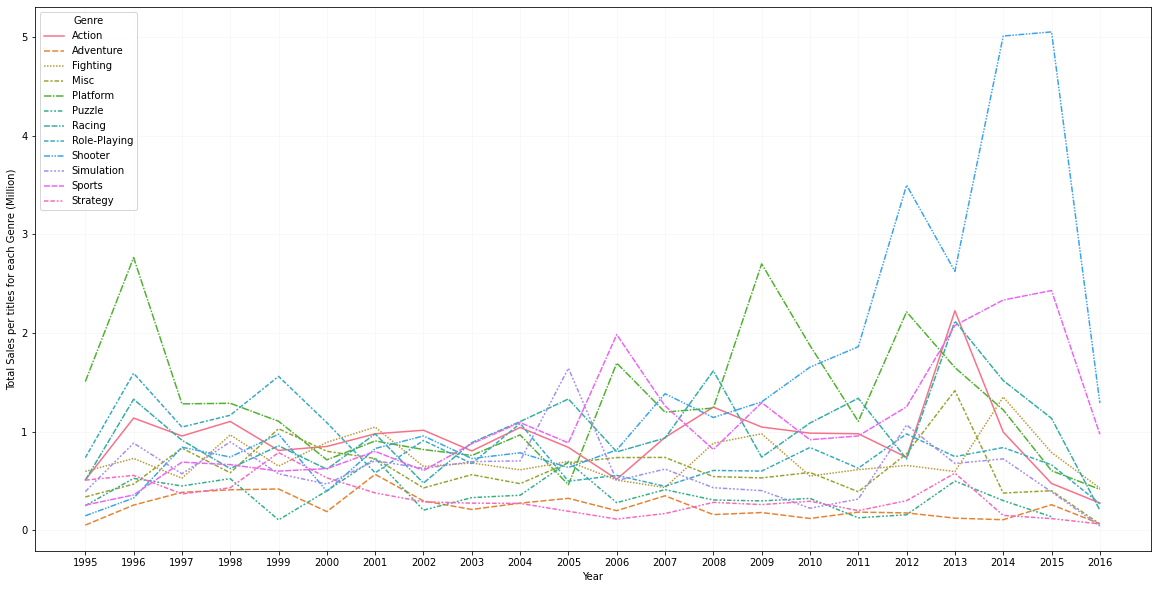

In [23]:
# 발매한 게임 수 대비 판매량
plt.figure(figsize=(20,10))
plt.grid(alpha=0.1)
plt.ylabel("Total Sales per titles for each Genre (Million)")
plt.xticks(ticks=np.arange(df_Y_S_per_n.index[0], df_Y_S_per_n.index[-1]+1, step=1))
sns.lineplot(data = df_Y_S_per_n)

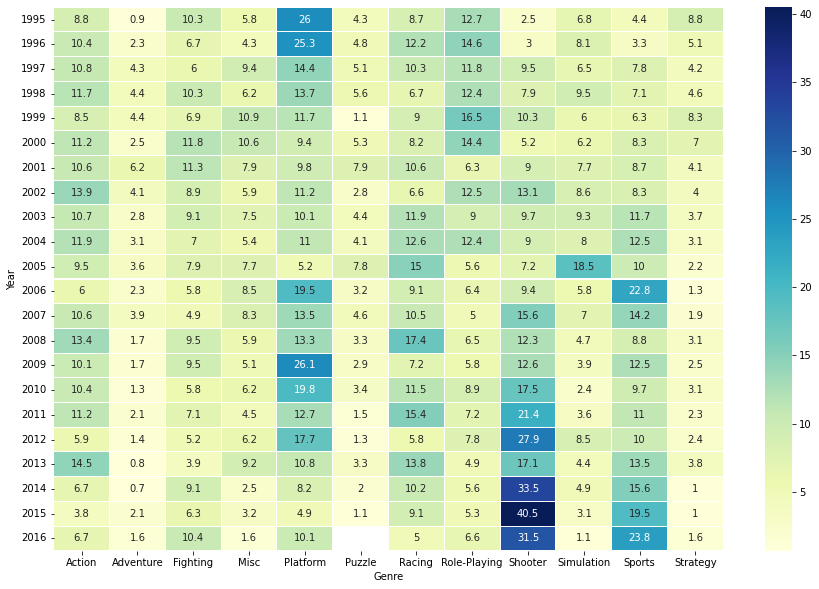

In [24]:
df_Y_S_per_n_percent = percent(df_Y_S_per_n.iloc[:,:])
heatmap(df_Y_S_per_n_percent)

## 결론( 2010년 이후 기준 )

1. 년도별 게임 트랜드는 어느정도 존재한다.
2. 장르별 판매량은 액션이 가장 높다.
3. 장르별 출시량은 액션이 가장 높다.
4. 출시량 대비 판매량은 슈터가 가장 높다.

# 3. 출고량이 높은 게임 타이틀

## 분석

In [25]:
l = 50 # 50등까지
m = 2010 # m년도 이후
df_hit = df_prep_title.loc[df_prep_title.loc[df_prep_title["Year"]>=m]["Total_Sales"].nlargest(l).index] # 상위 판매량 l위
df_hit.head()

,Year,Platform,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
Name,,,,,,,,,
Grand Theft Auto V,2013,"{X360, XOne, PC, PS4, PS3}",Action,Take-Two Interactive,23.46,23.04,1.39,8.03,55.92
Call of Duty: Black Ops,2010,"{DS, X360, PC, Wii, PS3}",Shooter,Activision,17.59,9.50,0.59,3.36,31.04
Call of Duty: Modern Warfare 3,2011,"{X360, PS3, Wii, PC}",Shooter,Activision,15.58,11.29,0.62,3.35,30.84
Call of Duty: Black Ops II,2012,"{X360, PC, PS3, WiiU}",Shooter,Activision,14.08,11.05,0.72,3.88,29.73
Call of Duty: Ghosts,2013,"{WiiU, X360, XOne, PC, PS4, PS3}",Shooter,Activision,14.92,9.05,0.48,2.92,27.37


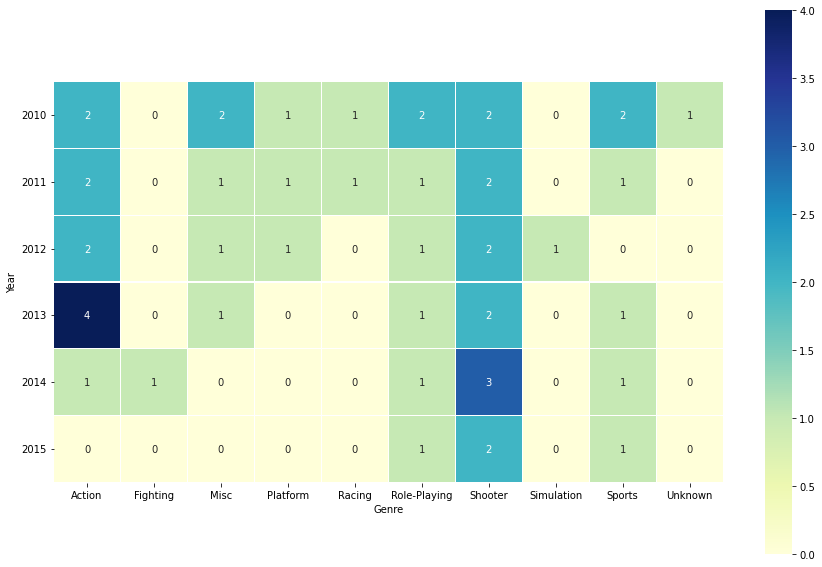

In [26]:
cross_hit_Y_G = pd.crosstab(df_hit["Year"],df_hit["Genre"])
heatmap(cross_hit_Y_G,square=True)

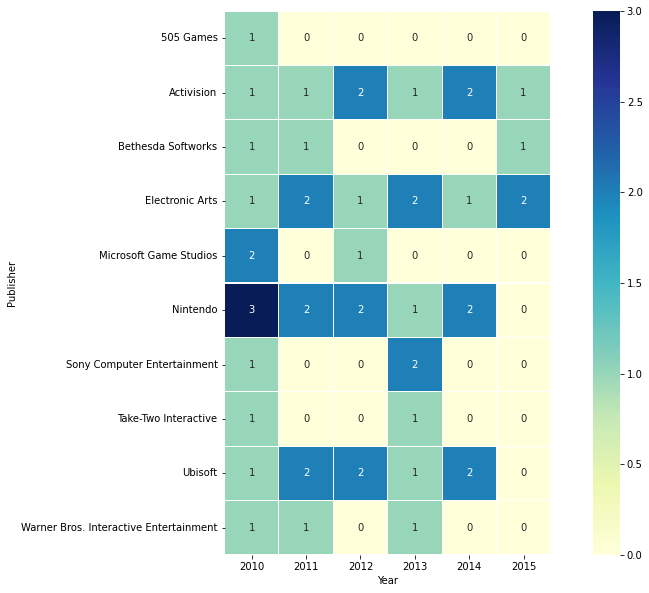

In [27]:
cross_hit_Y_PB = pd.crosstab(df_hit["Year"],df_hit["Publisher"])
heatmap(cross_hit_Y_PB.T, figsize=(15,10), rotation=(None, None), ha="center",square=True)

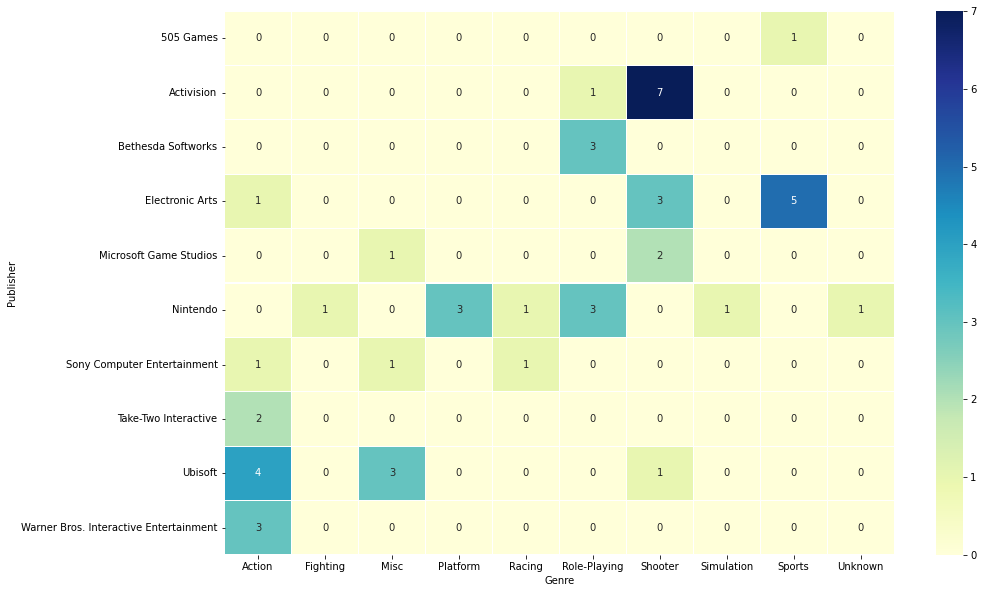

In [28]:
cross_hit_PB_G = pd.crosstab(df_hit["Publisher"],df_hit["Genre"])
heatmap(cross_hit_PB_G, figsize=(15,10))

## 결론 ( 2010년 이후, 판매량 상위 30개 게임 )

1. 특정 퍼블리셔는 특정 장르 게임에 대한 출고량이 높다.
2. 2010년 초반대와 2010년 중반대의 출고량이 높은 게임 장르가 다르다.
3. 출고량이 높은 게임을 출시하는 퍼블리셔는 년도와 상관없이 어느정도 출고량이 높은 게임을 출시한다.

# 4. 다음 분기 설계할 게임

## 분석
최근 동향을 반영하기 위해 2010년 이후 게임으로 조사

In [29]:
#장르, 플랫폼, 배급사의 우선순위를 정하기 위해 각각 분산도를 조사
print("Publisher")
print(df_prep.groupby("Publisher")["Total_Sales"].sum().describe())
print()
print("Platform")
print(df_prep.groupby("Platform")["Total_Sales"].sum().describe())
print()
print("Genre")
print(df_prep.groupby("Genre")["Total_Sales"].sum().describe())

Publisher
count     578.000000
mean       15.425346
std       103.240360
min         0.010000
25%         0.070000
50%         0.320000
75%         1.637500
max      1786.360000
Name: Total_Sales, dtype: float64

Platform
count      31.000000
mean      287.608065
std       351.871598
min         0.030000
25%        22.150000
50%       200.040000
75%       287.190000
max      1255.770000
Name: Total_Sales, dtype: float64

Genre
count      13.000000
mean      685.834615
std       496.455841
min        37.800000
25%       243.470000
50%       727.790000
75%       919.380000
max      1741.230000
Name: Total_Sales, dtype: float64




1.   장르
2.   플랫폼
3.   퍼블리셔



### 장르 분석

In [30]:
df_prep_title[(df_prep_title["Year"]>=m)&(df_prep_title["Year"]<2020)].sort_values("Genre")

,Year,Platform,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
Name,,,,,,,,,
Hanaoni: Yume no Tsudzuki,2012,{PSP},Action,Idea Factory,0.00,0.00,0.04,0.00,0.04
FIFA Soccer 13,2012,"{PSV, WiiU, 3DS, X360, PSP, PC, Wii, PS3}",Action,Electronic Arts,2.64,10.25,0.23,3.03,16.15
NES Remix,2014,{WiiU},Action,Nintendo,0.20,0.00,0.08,0.02,0.30
Sengoku Basara 3 Utage,2011,"{Wii, PS3}",Action,Capcom,0.00,0.00,0.35,0.00,0.35
Sengoku Basara 4,2014,{PS3},Action,Capcom,0.00,0.00,0.27,0.00,0.27
...,...,...,...,...,...,...,...,...,...
Princess Saver! Eternal Love for My Lady,2010,{PS2},Unknown,Comfort,0.00,0.00,0.02,0.00,0.02
Ukiyo no Shishi,2015,{PS3},Unknown,Namco Bandai Games,0.00,0.00,0.03,0.00,0.03
Treasure Report: Kikai Jikake no Isan,2011,{DS},Unknown,Namco Bandai Games,0.00,0.00,0.05,0.00,0.05


<function matplotlib.pyplot.show>

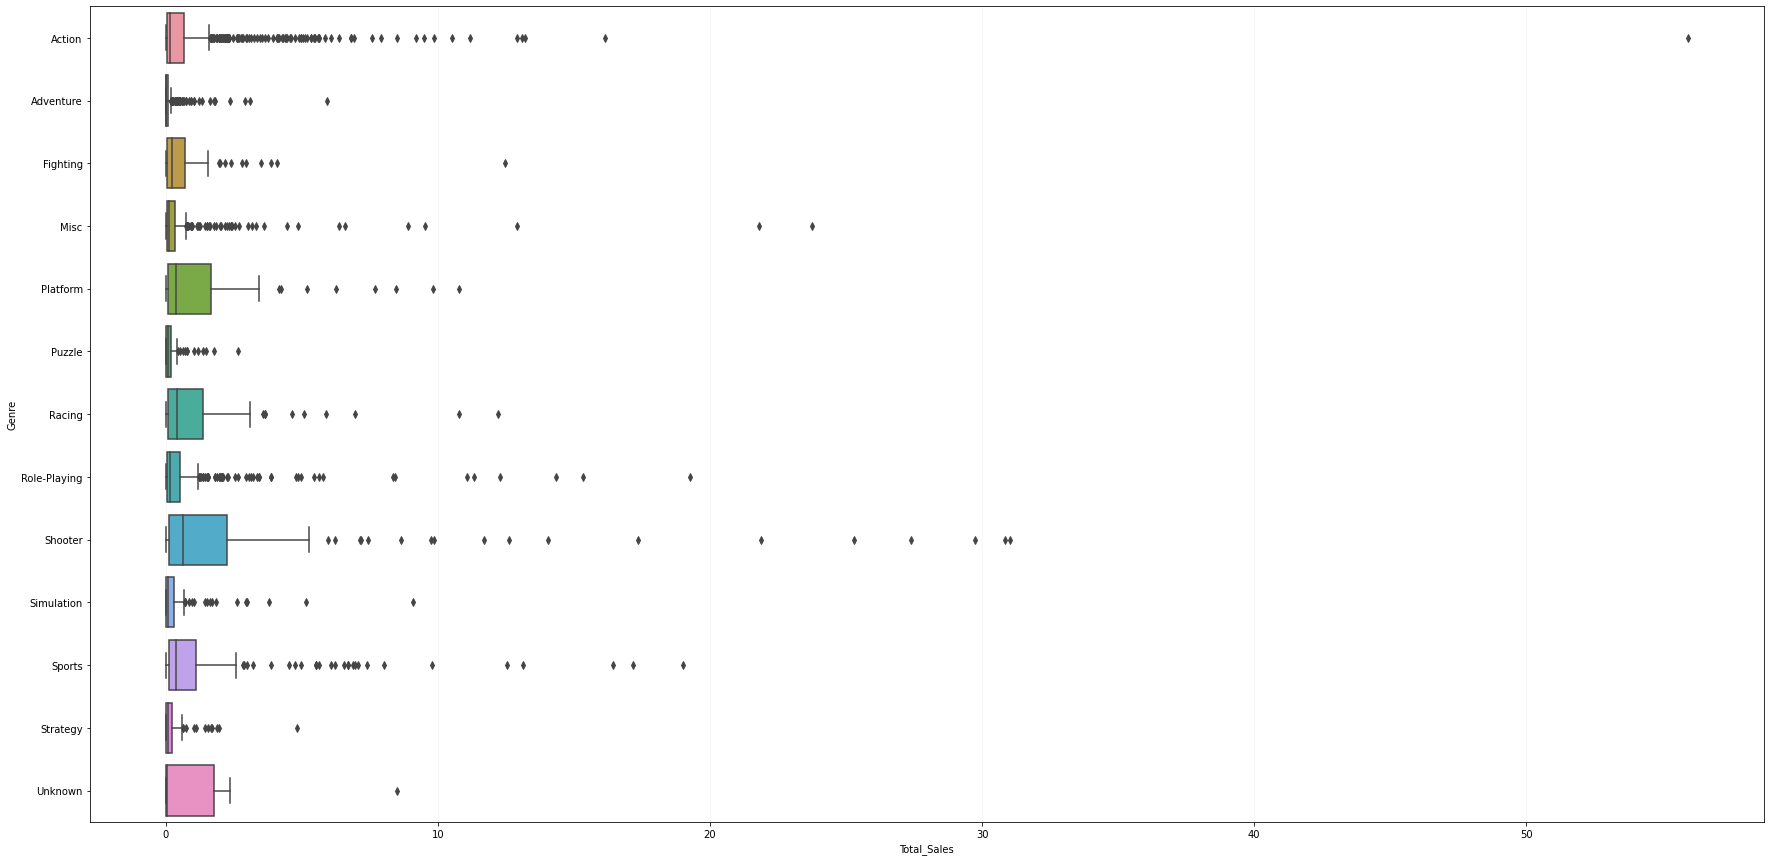

In [31]:
# 2010년 이후 장르별 box plot 확인.
plt.figure(figsize=(30,15))
plt.grid(alpha=0.1)
sns.boxplot(y="Genre", x="Total_Sales", data=df_prep_title[(df_prep_title["Year"]>=m)&(df_prep_title["Year"]<2020)].sort_values("Genre"))
plt.show

<function matplotlib.pyplot.show>

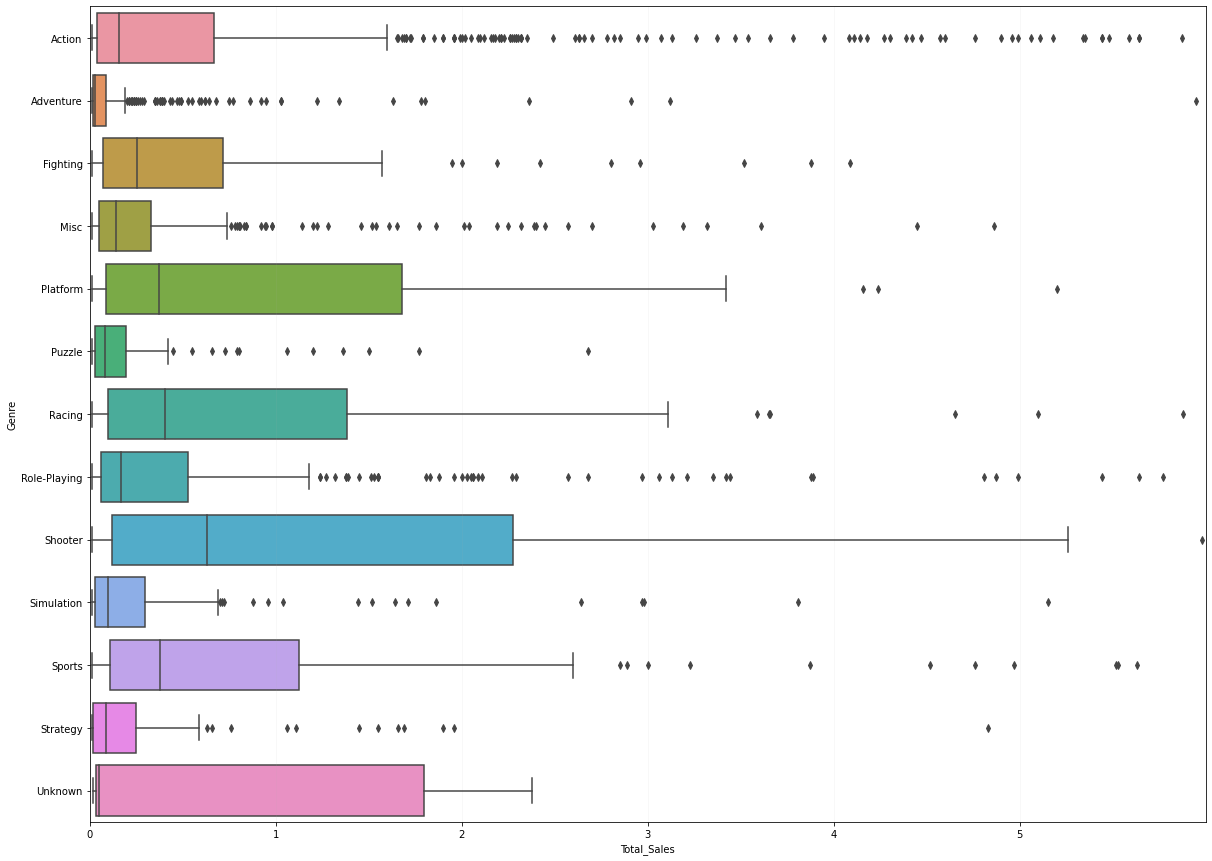

In [32]:
# 확대
plt.figure(figsize=(20,15))
plt.grid(alpha=0.1)
plt.xticks(np.arange(0,6))
plt.xlim((0,6))
sns.boxplot(y="Genre", x="Total_Sales", data=df_prep_title[(df_prep_title["Year"]>=m)&(df_prep_title["Year"]<2020)].sort_values("Genre"))
plt.show

역시 게임 제작수가 가장 많은 액션 장르는 100만장 상 판 게임 수는 많다고 볼 수 있지만, 전체적으로 봤을 때는 오히려 평균 판매량이 저조한 것을 확인할 수 있다.

1, 2, 3의 결과를 봤을 때, 액션 장르는 성공한 게임 수는 많지만, 이는 출시량이 많아서인 것으로 보이고, 게임 당 판매량이 낮아서 최소한의 판매량을 보장받기 어려울 것으로 보인다. 

또한, 출시량이 많은 액션 장르는 장르 내 경쟁률이 높을 것으로 예상된다.

따라서 출시량 대비 판매량이 높고, 높은 판매량의 게임을 다수 출시한 슈터 장르가 적절할 것으로 보인다.


In [33]:
# 장르 : 슈터 장르 분석
df_shooter_2010 = df_prep_title[(df_prep_title["Genre"]=="Shooter")&(df_prep_title["Year"]>=m)&(df_prep_title["Year"]<2020)].sort_values("Year")
df_shooter_2010["Total_Sales"].describe()

count    183.000000
mean       2.505738
std        5.380196
min        0.010000
25%        0.120000
50%        0.630000
75%        2.275000
max       31.040000
Name: Total_Sales, dtype: float64

In [34]:
df_shooter_2010[df_shooter_2010["Total_Sales"]>=3].sort_values("Total_Sales",ascending=False)

,Year,Platform,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
Name,,,,,,,,,
Call of Duty: Black Ops,2010,"{DS, X360, PC, Wii, PS3}",Shooter,Activision,17.59,9.50,0.59,3.36,31.04
Call of Duty: Modern Warfare 3,2011,"{X360, PS3, Wii, PC}",Shooter,Activision,15.58,11.29,0.62,3.35,30.84
Call of Duty: Black Ops II,2012,"{X360, PC, PS3, WiiU}",Shooter,Activision,14.08,11.05,0.72,3.88,29.73
Call of Duty: Ghosts,2013,"{WiiU, X360, XOne, PC, PS4, PS3}",Shooter,Activision,14.92,9.05,0.48,2.92,27.37
Call of Duty: Black Ops 3,2015,"{X360, XOne, PC, PS4, PS3}",Shooter,Activision,11.89,9.56,0.43,3.42,25.30
Call of Duty: Advanced Warfare,2014,"{X360, XOne, PC, PS4, PS3}",Shooter,Activision,10.44,8.18,0.34,2.93,21.89
Battlefield 3,2011,"{X360, PS3, PC}",Shooter,Electronic Arts,8.20,6.49,0.41,2.27,17.37
Battlefield 4,2013,"{X360, XOne, PC, PS4, PS3}",Shooter,Electronic Arts,6.41,5.57,0.46,1.60,14.04
Destiny,2014,"{X360, PS4, XOne, PS3}",Shooter,Activision,6.59,4.12,0.28,1.62,12.61


In [35]:
# 슈터 장르의 Top 10 퍼블리셔의 총 판매량 
df_shooter_2010_P = df_shooter_2010.iloc[:,[3,-1]].groupby("Publisher").describe().iloc[:,:2]
df_shooter_2010_P[("Total_Sales","Total_Sales")] = df_shooter_2010_P.iloc[:,0] * df_shooter_2010_P.iloc[:,1]
df_shooter_2010_P[df_shooter_2010_P[("Total_Sales","Total_Sales")]>=0].sort_values(("Total_Sales","Total_Sales"),ascending=False).head(10) 

Total_Sales                      
                                  count      mean Total_Sales
Publisher                                                    
Activision                         22.0  8.747727      192.45
Electronic Arts                    15.0  4.936000       74.04
Microsoft Game Studios             11.0  3.904545       42.95
Ubisoft                            10.0  3.055000       30.55
Take-Two Interactive               14.0  2.126429       29.77
Sony Computer Entertainment        14.0  1.376429       19.27
Bethesda Softworks                  5.0  2.450000       12.25
Sega                                8.0  1.080000        8.64
Capcom                              6.0  1.276667        7.66
Nintendo                            3.0  1.960000        5.88

위 결과를 봤을 때 적절한 퍼블리셔는

1.   Activision
2.   Electronic Arts
3.   Microsoft Game Studio
4.   Ubisoft
5.   Take-Two Interactive

이다. 특히 대작 비율이 높은 Activision에 출시할 목표로 삼으면 될 것 같다.

### 플랫폼 선호도

In [36]:
# 플래폼 별 판매량
df_R_P = df_prep.groupby("Platform").sum().drop("Year",axis=1).transpose()
df_R_P

Platform,2600,3DO,3DS,DC,DS,GB,GBA,GC,GEN,GG,N64,NES,NG,PC,PCFX,PS,PS2,PS3,PS4,PSP,PSV,SAT,SCD,SNES,TG16,WS,Wii,WiiU,X360,XB,XOne
NA_Sales,90.60,0.0,78.87,5.43,390.71,114.32,187.54,133.46,19.27,0.00,139.02,125.94,0.00,93.28,0.00,336.51,583.84,392.26,96.80,108.99,16.20,0.72,1.00,61.23,0.00,0.00,507.71,38.32,601.05,186.69,83.19
EU_Sales,5.47,0.0,58.52,1.69,194.65,47.82,75.25,38.71,5.52,0.00,41.06,21.15,0.00,139.68,0.00,213.60,339.29,343.71,123.70,68.25,16.33,0.54,0.36,19.04,0.00,0.00,268.38,24.23,280.58,60.95,45.65
JP_Sales,0.00,0.1,97.35,8.56,175.57,85.12,47.33,21.58,2.67,0.04,34.22,98.65,1.44,0.17,0.03,139.82,139.20,79.99,14.30,76.79,20.96,32.26,0.45,116.55,0.16,1.42,69.35,12.79,12.43,1.38,0.34
Other_Sales,0.91,0.0,12.63,0.27,60.53,8.20,7.73,5.18,0.89,0.00,4.38,5.31,0.00,24.86,0.00,40.91,193.44,141.93,43.36,42.19,8.45,0.07,0.05,3.22,0.00,0.00,80.61,6.45,85.54,8.72,11.92
Total_Sales,96.98,0.1,247.37,15.95,821.46,255.46,317.85,198.93,28.35,0.04,218.68,251.05,1.44,257.99,0.03,730.84,1255.77,957.89,278.16,296.22,61.94,33.59,1.86,200.04,0.16,1.42,926.05,81.79,979.60,257.74,141.10


In [37]:
df_Y_P_pivot = df_prep.groupby(["Year","Platform"]).sum().iloc[:,-1:].reset_index().pivot(index="Year",columns="Platform").fillna(0)
df_Y_P_pivot.columns = df_Y_P_pivot.columns.get_level_values(1)
# df_Y_P_pivot["Total_Sales"] = df_Y_P_pivot.sum(axis=1)
df_Y_P_pivot = df_Y_P_pivot.iloc[:-1]

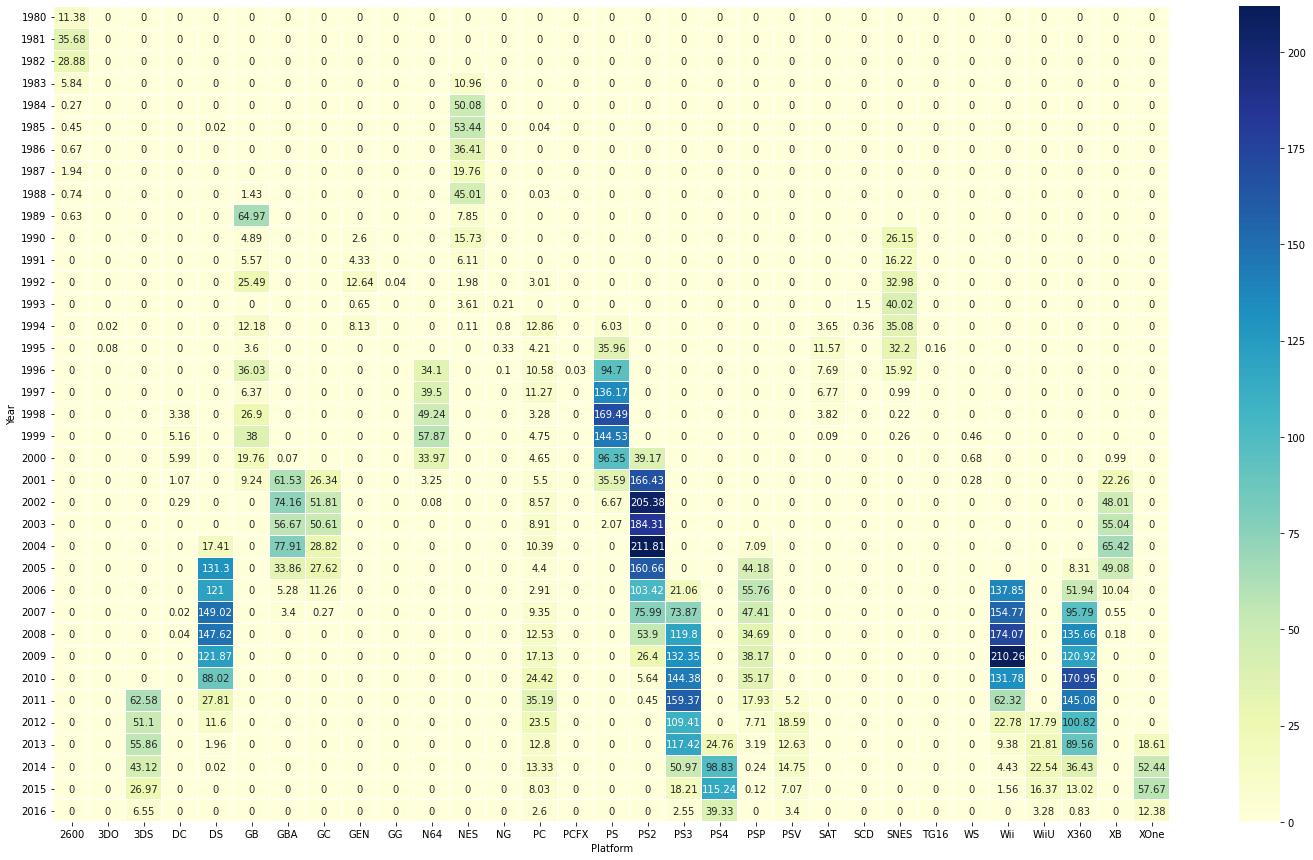

In [38]:
heatmap(df_Y_P_pivot, figsize=(25,15))

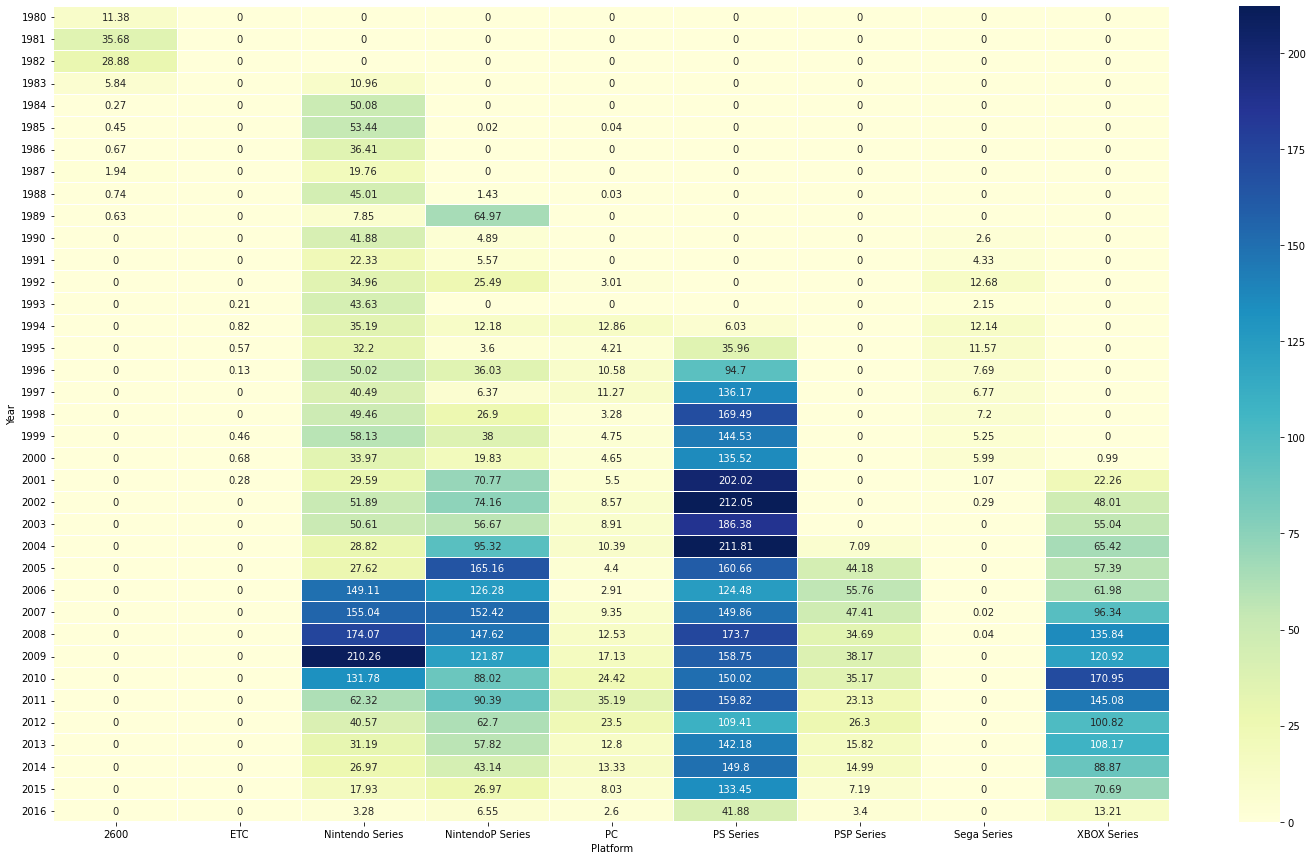

In [39]:
# 플랫폼 시리즈 별로 묶기
df_prep_Pseries = df_prep.copy() 

def platform_series (x) :
    if (x == "PS") | (x == "PS2") | (x == "PS3") | (x == "PS4") : return "PS Series" # PS 거치형
    elif (x == "X360") | (x == "XB") | (x == "XOne") : return "XBOX Series" # XBOX 거치형
    elif (x == "PSP") | (x == "PSV") : return "PSP Series" # PS 휴대용
    elif (x == "GB") | (x == "GBA") | (x == "DS") | (x == "3DS") : return "NintendoP Series" # 닌텐도 휴대형
    elif (x == "N64") | (x == "GC") | (x == "NES") | (x == "SNES") | (x == "Wii") | (x == "WiiU") : return "Nintendo Series" #닌텐도 거치형
    elif (x == "DC") | (x == "GEN") | (x == "GG") | (x == "SAT") | (x == "SCD") : return "Sega Series" # 세가 거치+휴대
    elif (x == "3DO") | (x == "NG") | (x == "TG16") | (x == "WS") | (x == "PCFX") : return "ETC" # 기타
    return x # PC
df_prep_Pseries["Platform"] = df_prep_Pseries["Platform"].apply(platform_series)
df_Y_PS_pivot = df_prep_Pseries.groupby(["Year","Platform"]).sum().iloc[:,-1:].reset_index().pivot(index="Year",columns="Platform").fillna(0)
df_Y_PS_pivot.columns = df_Y_PS_pivot.columns.get_level_values(1)
# df_Y_PS_pivot["Total_Sales"] = df_Y_PS_pivot.sum(axis=1)
df_Y_PS_pivot = df_Y_PS_pivot.iloc[:-1]
df_Y_PS_pivot
heatmap(df_Y_PS_pivot, figsize=(25,15))

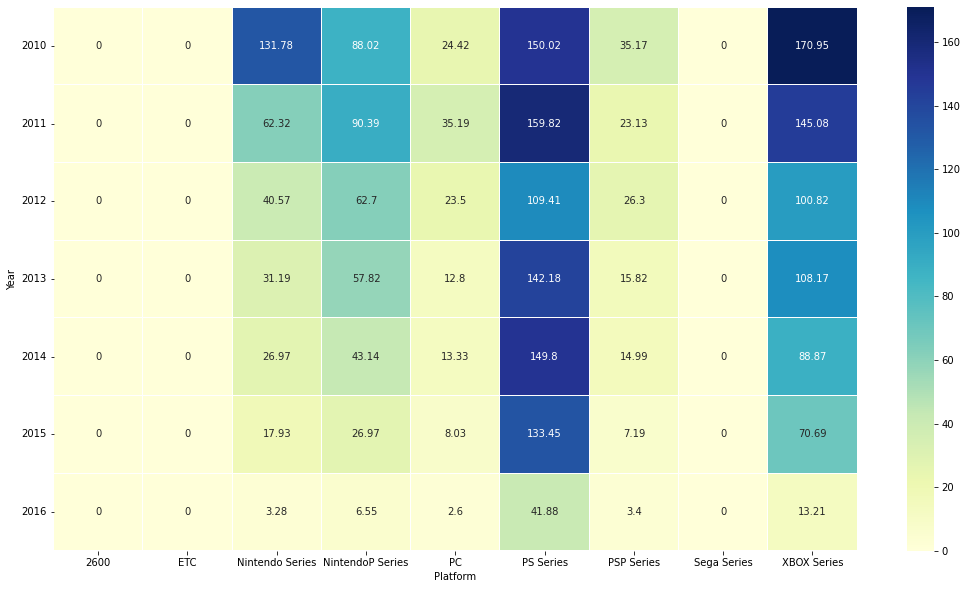

In [40]:
heatmap(df_Y_PS_pivot.iloc[-7:], figsize=(18,10))

최근 10년을 보면 플레이 스테이션 시리즈와 XBOX 시리즈에 판매량이 많다.

### 장르 + 플랫폼 확인

In [41]:
# 2010년 이후 데이터 사용
df_prep_Pseries[(df_prep_Pseries["Year"]>=m)&(df_prep_Pseries["Year"]<2020)].set_index("Name")

,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Total_Sales
Name,,,,,,,,,
Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP Series,2010,Adventure,Alchemist,0.00,0.00,0.02,0.00,0.02
Deal or No Deal: Special Edition,NintendoP Series,2010,Misc,Zoo Games,0.04,0.00,0.00,0.00,0.04
Ben 10 Ultimate Alien: Cosmic Destruction,PS Series,2010,Platform,D3Publisher,0.12,0.09,0.00,0.04,0.25
JASF: Jane's Advanced Strike Fighters,PC,2011,Simulation,Deep Silver,0.02,0.01,0.00,0.00,0.03
The Penguins of Madagascar: Dr. Blowhole Returns - Again!,PS Series,2011,Action,THQ,0.04,0.03,0.00,0.01,0.08
...,...,...,...,...,...,...,...,...,...
LEGO The Hobbit,XBOX Series,2014,Action,Warner Bros. Interactive Entertainment,0.13,0.12,0.00,0.02,0.27
MindJack,PS Series,2011,Shooter,Square Enix,0.07,0.08,0.00,0.03,0.18
White Album: Tsuzurareru Fuyu no Omoide,PS Series,2010,Adventure,Aqua Plus,0.00,0.00,0.05,0.00,0.05


In [42]:
# 콘솔 시리즈의 장르별 판매량
df_prep_PS_title = df_prep_Pseries[(df_prep_Pseries["Year"]>=m)&(df_prep_Pseries["Year"]<2020)].iloc[:,[1,3,9]].groupby(["Genre","Platform"]).sum().reset_index().pivot(index="Platform",columns="Genre").fillna(0)
df_prep_PS_title.columns = df_prep_PS_title.columns.get_level_values(1)
df_prep_PS_title

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy,Unknown
Platform,,,,,,,,,,,,,
Nintendo Series,64.38,3.81,8.19,93.56,51.44,3.99,13.24,6.76,10.77,3.92,42.18,3.01,8.79
NintendoP Series,80.52,12.81,11.42,29.50,39.33,16.19,18.00,112.52,2.65,36.13,9.77,6.70,0.05
PC,21.39,2.00,0.13,0.92,0.31,0.67,2.69,28.41,24.38,14.63,7.14,17.16,0.04
PS Series,288.56,21.65,35.66,28.42,20.62,0.06,50.30,77.17,206.72,7.13,143.23,3.02,4.02
PSP Series,35.33,10.30,7.02,9.31,3.51,0.28,3.79,33.15,5.59,1.01,13.16,3.45,0.10
XBOX Series,179.37,10.39,19.11,67.59,5.54,0.00,35.63,47.64,212.53,8.16,108.80,2.47,0.56


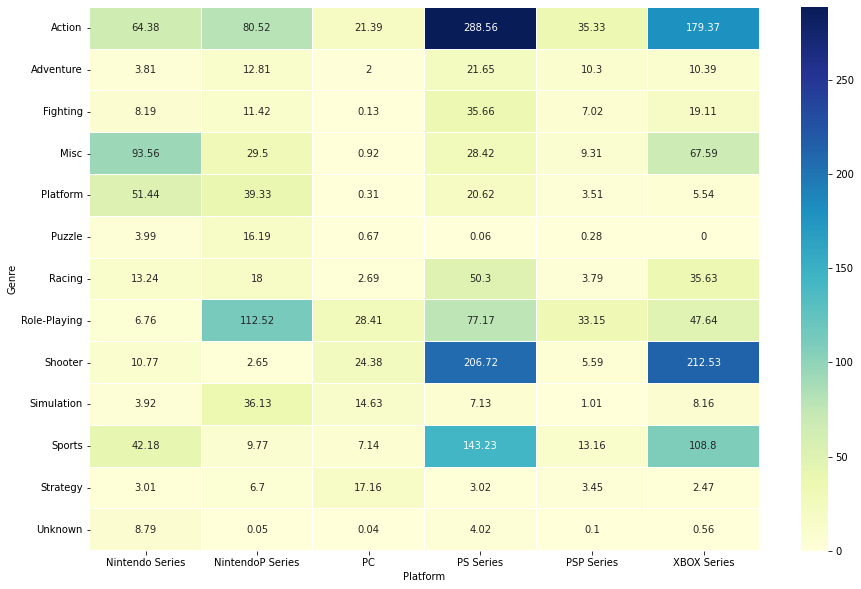

In [43]:
heatmap(df_prep_PS_title.transpose())#.sort_values(("Shooter"),ascending=False)

위 결과를 봤을때, 슈터 장르 게임을 제작한다면 기본적으로 XBOX와 PS용으로 게임을 개발하고, 가능하면 PC까지 포함해서 개발을 진행하면 좋을 것 같다.

## 결론

1. 장르는 슈터
2. 플랫폼은 PS 시리즈와 XBOX 시리즈, 가능하면 PC까지
3. 퍼블리셔는 Activision, Electronic Arts, Microsoft Game Studio, Ubisoft, Take-Two Interactive